# Programming Assignment 3: Stochastic Filtering

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import bernoulli, norm
from __future__ import division
print "Modules Imported!"

Modules Imported!


## 1. Hidden Markov Models

Recall that a declarative description for a Hidden Markov Model with a finite state space ${\mathsf X}$ and a finite observation space ${\mathsf Y}$ consists of the following objects:

* initial state distribution $p_0$, i.e., the pmf of $X_0$
* state transition matrix $M = [M(x,x')]_{x,x' \in {\mathsf X}}$, where

$$
M(x,x') = {\bf P}[X_{t+1}=x'|X_t=x]
$$

* observation model $T = [T(x,y)]_{x \in {\mathsf X} ,y \in {\mathsf Y}}$, where

$$
T(x,y) = {\bf P}[Y_t = y|X_t=x].
$$

Then, for any $t =1,2,3,\ldots$, the joint distribution of the hidden state sequence $X^t_0$ and the observation sequence $Y^t_1$ is given by

$$
{\bf P}[X^t_0=x^t_0,Y^t_1 = y^t_1] = p_0(x_0) \cdot \prod^{t-1}_{s=0} M(x_s,x_{s+1}) T(x_{s+1},y_{s+1}).
$$

<b>Problem 1a.</b> In the code cell below, write a function `HMMSample(p0,M,T,t)` that takes as input the declarative description $(p_0,M,T)$ and a time horizon $t \in {\mathbb N}$ and generates the random sequences $X^t_0$ and $Y^t_1$.

Import additional modules as needed.

In [1]:
###### student code goes here ######
def HMMSample(p0, M, T, t):
    """
    In this function, the values X and Y can take are {0,1}
    Thus, the shape of transition mantrices M, T would be 2x2.
    In the initial distribution p0. p0(1) = P(X0=1)
    """
    # since only 0 and 1 are valid values, set -1 as initial values.
    X = -np.ones(t+1, dtype='int')
    Y = -np.ones(t+1, dtype='int')
    X[0] = bernoulli.rvs(p0[1])
    for s in xrange(1, t+1):
        X[s] = bernoulli.rvs(M[X[s-1], 1])
        Y[s] = bernoulli.rvs(T[X[s], 1])
    return X, Y

As a sanity check, print the output of your code with the following settings:

$$
 p_0 = \left(\frac{1}{2},\frac{1}{2}\right), \quad M = \left( \begin{matrix} 0 & 1 \\ 1 & 0 \end{matrix} \right), \quad T = \left(\begin{matrix} 1 & 0 \\ 0 & 1 \end{matrix}\right).
$$

Are you seeing what you were expecting?

In [67]:
###### student code goes here ######

p0 = np.array([1/2, 1/2])
M = np.array([[0,1],[1,0]])
T = np.array([[1,0],[0,1]])

X, Y = HMMSample(p0, M, T, 10)
print "The sequences generated:\nX (from 0 to t): {}\nY (from 1 to t):   {}".format(X,Y[1:])

The sequences generated:
X (from 0 to t): [0 1 0 1 0 1 0 1 0 1 0]
Y (from 1 to t):   [1 0 1 0 1 0 1 0 1 0]


<b>Problem 1b.</b> In the code cell below, write a function `HMMPredict(p,M)` that takes as input a belief (i.e., a pmf over the state space ${\mathsf X}$) and the transition matrix of the hidden state process and implements the prediction step

$$
\pi_{t|t} \longrightarrow \pi_{t+1|t}
$$

of the HMM filtering recursion.

---
Prediction rule:
$$
\Pi_{t+1|t} = \Pi_tM
$$

In [277]:
###### student code goes here ######
def HMMPredict(p, M):
    "see prediction rule above"
    return np.dot(p, M)

<b>Problem 1c.</b> In the code cell below, write a function `HMMCorrect(p,M,T,y)` that takes as input a belief, the transition and the observation matrices of the HMM, and an observation and implements the correction step

$$
\pi_{t+1|t} \longrightarrow \pi_{t+1|t+1}
$$

of the HMM recursion.

---
Correction rule:
$$\Pi_{t+1}(a) = \frac{\Pi_{t+1|t}(a)T(a, y_{t+1})}{\sum_{b \in X}\Pi_{t+1|t}(b)T(b, y_{t+1})}
$$

In [2]:
###### student code goes here ######

def HMMCorrect(predict, T, y):
    "see correction rule above"
    # predict, T[:,y] element-wise multiplication
    nume = predict * T[:,y]
    return nume / nume.sum()

<b>Problem 1d.</b> Use your answers from the previous parts to write a function `HMMFilter(p_0,M,T,t)` that implements the HMM filtering recursion for the declarative model $(p_0,M,T)$ over a horizon $t$.

In [71]:
###### student code goes here ######
def HMMFilter(p0, M, T, t, Y):
    pi = np.zeros((t+1, 2))
    pi[0,:] = p0
    for s in xrange(1, t+1):
        predict = HMMPredict(pi[s-1,:], M)
        pi[s,:] = HMMCorrect(predict, T, Y[s])
    return pi
    
    

<b>Problem 1e.</b> Consider the following problem specification: $p_0 = {\rm Bernoulli}(1/2)$, 

$$
M = \left( \begin{matrix} 0.8 & 0.2 \\ 0.2 & 0.8 \end{matrix}\right), \quad T = \left( \begin{matrix} 0.4 & 0.6 \\ 0.6 & 0.4 \end{matrix}\right), \quad t = 100.
$$

Use your code in Problem 1d to run the HMM filter recusion with this specification, and then to generate the following output: the hidden state sequence $X_1,X_2,\ldots,X_{100}$, the posterior probabilities $\pi_1(1),\ldots,\pi_{100}(1)$, and the error rate

$$
\frac{\text{number of times $\pi_t(1) > 1/2$ and $X_t = 1$}}{\text{number of times $X_t = 1$}}.
$$

In [274]:
###### student code goes here ######

# parameters initialization
M = np.array([[0.8,0.2],[0.2, 0.8]])
T = np.array([[0.4,0.6],[0.6,0.4]])
t = 100
# produce hidden states and observation samples
X, Y = HMMSample(p0, M, T, t)
# filter recursion
pi = HMMFilter(p0, M, T, t, Y)

# success rate
(np.logical_and(pi[1:,1] > 0.5, X[1:]==1)).sum() / (X[1:]==1).sum()

0.64583333333333337

## 2. The scalar Kalman Filter

Consider the following Hidden Markov Model with continuous states and observations: $X_0 \sim N(m_0,\sigma^2_0)$, and

\begin{align*}
X_t &= a X_{t-1} + b U_t \\
Y_t &= c X_t + d V_t
\end{align*}

for $t=1,2,\ldots$, where $U_t$ are i.i.d. $N(0,1)$, $V_t$ are i.i.d. $N(0,1)$, and $X_0,U,V$ are mutually independent.

<b>Problem 2a:</b> In the code cell below, write a function `KFSample(mean0,var0,a,b,c,d,t)` that takes as input the model parameters $m_0,\sigma^2_0,a,b,c,d$ and a time horizon $t \in {\mathbb N}$ and generates the random sequences $X^t_0$ and $Y^t_1$.

Import additional modules as needed.

In [2]:
###### student code goes here ######
def KFSample(mean0, var0, a, b, c, d, t):
    X = -np.zeros(t+1)
    Y = -np.zeros(t+1)
    X[0] = norm.rvs(mean0, var0)
    Y[0] = np.nan
    for s in xrange(1, t+1):
        X[s] = a * X[s-1] + b * norm.rvs(0, 1)
        Y[s] = c * X[s] + d * norm.rvs(0, 1)
    return X, Y

<b>Problem 2b.</b> In the code cell below, write a function `KFPredict(mean,var,a,b,c,d)` that takes as input the mean and the variance of a Gaussian belief (i.e., a Gaussian pdf on the state space ${\mathsf X} = {\mathbb R})$ and implements the prediction step of the Kalman filter:

$$
(m_{t|t},\Sigma_{t|t}) \longrightarrow (m_{t+1|t},\Sigma_{t+1|t}).
$$

<b>Caution:</b> note the coefficients $b$ and $d$ multiplying the state and the observation noise.

---
Predict rule:
$$
m_{t+1|t} = a m_{t|t} \\
\Sigma_{t+1|t} = a^2 \Sigma_{t|t} + b^2 \sigma_U^2
$$

In [3]:
###### student code goes here ######
def KFPredict(mean, var, a, b):
    """
    see predict rule above
    """
    predict_mean = a * mean
    predict_var = pow(a,2) * var + pow(b,2)
    return (predict_mean, predict_var)

<b>Problem 2c.</b> In the code cell below, write a function `KFCorrect(mean,var,a,b,c,d,y)` that takes as input the mean and the variance of a Gaussian belief and implements the correction step of the Kalman filter:

$$
(m_{t+1|t},\Sigma_{t+1|t}) \longrightarrow (m_{t+1|t+1},\Sigma_{t+1|t+1}).
$$

---
Correction rule:
$$
m_{t+1|t+1} = \frac{c y_{t+1}\Sigma_{t+1|t} + m_{t+1|t} \sigma_V^2 d^2 }{c^2 \Sigma_{t+1|t} + \sigma_V^2 d^2}\\
\Sigma_{t+1|t+1} = \frac{\Sigma_{t+1|t} \sigma_V^2 d^2}{c^2 \Sigma_{t+1|t} + \sigma_V^2 d^2}
$$


In [4]:
###### student code goes here ######
def KFCorrect(predict_mean, predict_var, c, d, y):
    """
    see correction rule above
    """
    mean = (c*predict_var*y + predict_mean*pow(d,2)) / (pow(c,2)*predict_var + pow(d,2))
    var = (predict_var*pow(d,2)) / (pow(c,2)*predict_var + pow(d,2))
    return (mean, var)

<b>Problem 2d.</b> Use your answers from the previous parts to write a function `KF(mean0,var0,a,b,c,d,t)` that implements the Kalman Filter over a horizon $t$.

In [11]:
###### student code goes here ######
def KF(mean0, var0, a, b, c, d, t, Y):
    mean = np.zeros(t+1)
    var = np.zeros(t+1)
    mean[0] = mean0
    var[0] = var0
    #pi[0], var[0] = mean0, var0
    for s in xrange(1, t+1):
        # get the prediction
        predict_mean, predict_var = KFPredict(mean[s-1], var[s-1], a, b)
        # correct prediction
        mean[s], var[s] = KFCorrect(predict_mean, predict_var, c, d, Y[s])
    return mean, var
    

<b>Problem 2e.</b> Consider the following model specification:

$$
m_0 = 2, \quad \sigma^2_0 = 0.5, \quad a = 1.5, \quad b = 0.3, \quad c = 1, \quad d = 0.5
$$

and the time horizion $t=100$. Use your code from Problem 2d to run the Kalman filter and generate the following two plots:

1. Plot the actual hidden state trajectory and the predicted mean trajectory versus time on the same set of axes.

2. Plot the posterior variance $\Sigma_t$ versus time.


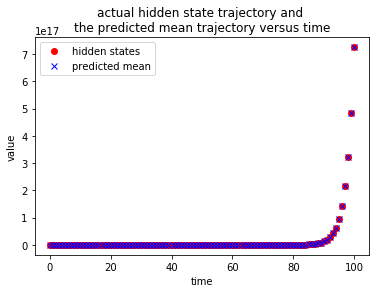

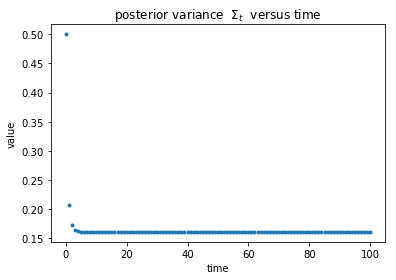

In [12]:
###### student code goes here ######

# parameters initialization
mean0, var0 = 2., 0.5
a,b,c,d = 1.5, 0.3, 1., 0.5
t = 100
# produce hidden states and observation samples
X, Y = KFSample(mean0, var0, a, b, c, d, t)
# filter recursion, get the means and vars
mean, var = KF(mean0, var0, a, b, c, d, t, Y)
## generate predicted hidden states based on the means and vars
#ps = np.zeros(t+1)
#for s in xrange(1, t+1):
#    ps[s] = norm.rvs(mean[s], var[s])

# plot
time = np.arange(t+1)
plt.figure()
plt.plot(time, X,'ro', label='hidden states')
plt.plot(time, mean,'bx', label='predicted mean')
plt.legend()
plt.xlabel('time')
plt.ylabel('value')
plt.title('actual hidden state trajectory and \nthe predicted mean trajectory versus time')

plt.figure()
plt.plot(time, var,'.')
plt.title('posterior variance  $\Sigma_t$  versus time')
plt.xlabel('time')
plt.ylabel('value')